# Gradient Boosting

The next classification model we will investigate is the Gradient Boosting Classifier.

## Importing the libraries

In [40]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd


# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# For creating the model
from sklearn.ensemble import GradientBoostingClassifier

#For evaluating the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, balanced_accuracy_score

In [41]:
import pickle

#Loading the training and test splits from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)

X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

## Importing the splits

In [42]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

In [43]:
split_data.keys()

dict_keys(['random', 'stratified', 'udersample', 'oversample'])

## Initial Model

Here, we'll create an initial classification model using the GradientBoostingClassifier function from scikit-learn and test it on our splits.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


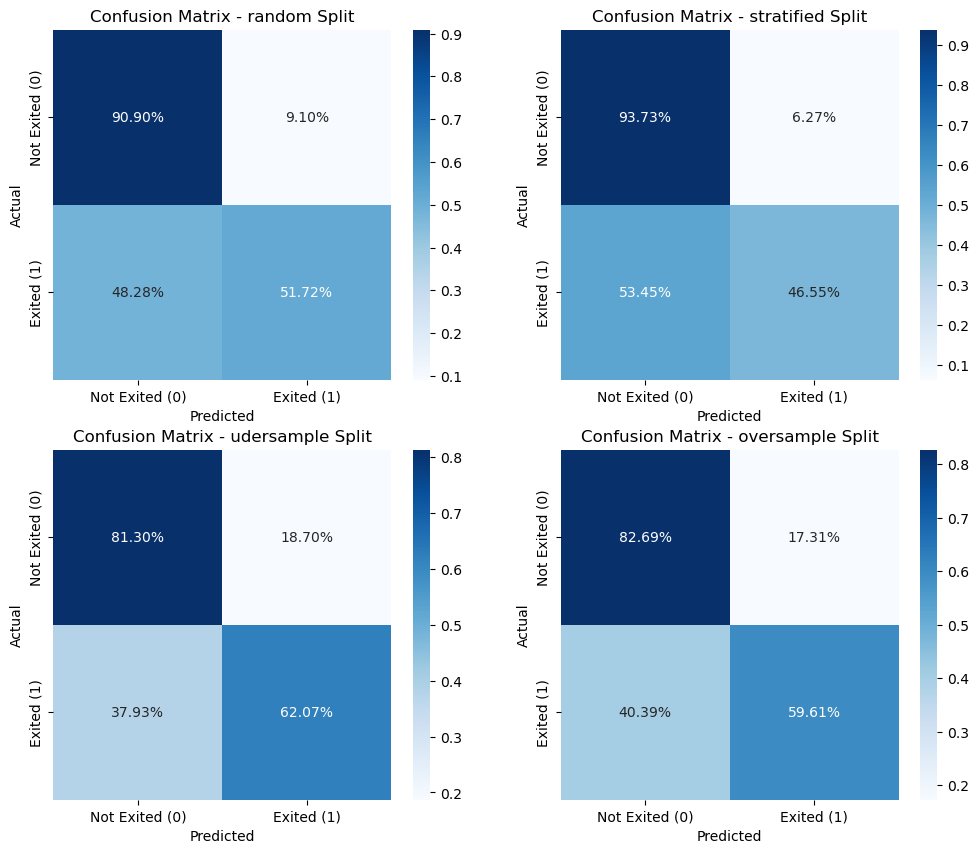

<Figure size 800x600 with 0 Axes>

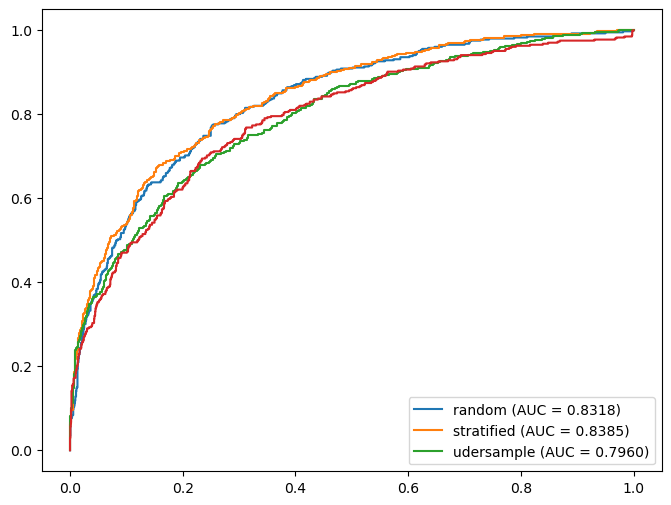

random - Validation Accuracy: 0.8569, Test Accuracy: 0.8295
random - Test Precision (Class 1): 0.7442
Test Recall (Class 1): 0.4790
Test F1-Score (Class 1): 0.5829
False Positives: 145, False Negatives: 196
stratified - Validation Accuracy: 0.8619, Test Accuracy: 0.8415
stratified - Test Precision (Class 1): 0.7333
Test Recall (Class 1): 0.5061
Test F1-Score (Class 1): 0.5989
False Positives: 100, False Negatives: 217
udersample - Validation Accuracy: 0.7863, Test Accuracy: 0.7740
udersample - Test Precision (Class 1): 0.4920
Test Recall (Class 1): 0.7395
Test F1-Score (Class 1): 0.5909
False Positives: 298, False Negatives: 154
oversample - Validation Accuracy: 0.7831, Test Accuracy: 0.7800
oversample - Test Precision (Class 1): 0.4866
Test Recall (Class 1): 0.7066
Test F1-Score (Class 1): 0.5763
False Positives: 276, False Negatives: 164


In [45]:
#We now need to create our Gradient Boosting Classification model

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)

#Create somewhere to store the performance metrics
performance ={}

#Creating 2x2 grid for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
plt.figure(figsize=(8,6))

#ROC Curve Figure
plt.figure(figsize=(8,6))

#Fit model for each of the 4 splits
for idx, split in enumerate(split_data):
    X_train, X_val, y_train, y_val =split_data[split]
    
    #Train model
    gb_model.fit(X_train, y_train)
    
    #Predict on validation set
    y_val_pred = gb_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    #Predict on unseen test set
    y_test_pred = gb_model.predict(X_test_raw)
    test_accuracy = accuracy_score(y_test_raw, y_test_pred)

    #Get general classification report
    test_report = classification_report(y_val, y_val_pred, output_dict = True)

    #Balanced accuracy, precision, recall, and F1-score for class 1 (positive class)
    precision = test_report['1']['precision']
    recall = test_report['1']['recall']
    f1_score = test_report['1']['f1-score']
    balanced_acc = balanced_accuracy_score(y_val, y_val_pred)

    #Plot confusion matrix for test set
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    #Normalize the confusion matrix by the number of true samples per class to get the values of the confusion matrix as a percentage of the total and labelling
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[idx].set_title(f'Confusion Matrix - {split} Split')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

    
    #Plot ROC curve on the same figure for all splits
    y_test_pred_prob = gb_model.predict_proba(X_test_raw)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
    roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)
    plt.legend(loc="lower right")
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')


    #Define performance metrics
    performance[split] = {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
         'test_precision_1': precision,
        'test_recall_1': recall,
        'test_f1_score_1': f1_score,
        'false_positives': fp,
        'false_negatives': fn,
        'balanced_accuracy': balanced_acc
    }

#Show the plots
plt.show()  

# Output performance metrics
for split, perf in performance.items():
    print(f"{split} - Validation Accuracy: {perf['val_accuracy']:.4f}, Test Accuracy: {perf['test_accuracy']:.4f}")
    print(f"{split} - Test Precision (Class 1): {perf['test_precision_1']:.4f}")
    print(f"Test Recall (Class 1): {perf['test_recall_1']:.4f}")
    print(f"Test F1-Score (Class 1): {perf['test_f1_score_1']:.4f}")
    print(f"False Positives: {perf['false_positives']}, False Negatives: {perf['false_negatives']}")

We can see from the ROC curve that the model performs fairly well on all splits, particularly on the oversample and undersample splits. This is to be expected due to the nature of the dataset we're considering as it is imbalanced and the over/undersampling accounts for this.

In the context of our problem, we're interested in getting a high Recall value from our models, since we want to make sure we identify the customers who are going to churn so that the bank can put retention methods in place. 

The effects of the imbalanced dataset can be seen when it comes to the Recall of the random and stratified splits. In both these cases, the make-up of the data in the validation and test sets is expected to be very similar to that of the full dataset. Therefore, when training our model it doesn't have much information to go off when it comes to the predicting those who will churn, since a significantly smaller number of those in our data do churn.

On the contrary, oversampling and undersampling generate balanced test sets and assist model performance leading to the improved performance we can see above. The Recall value in undersampling and oversampling are of a satisfactory level.

In terms of accuracy, the initial Gradient Boosting Classifier model outperforms the baseline on both fronts.

In the following, we'll attempt to refine and improve the model by adjusting the parameters.